In [1]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")
overlay.load_model("./xmodel/dpu_enet_cityscapes.xmodel")

/usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/ps.py:434: UserWarning: Setting frequency to the closest possible value 98.8879MHz.
  warnings.warn(


In [2]:
import numpy as np
import cv2
import os
from PIL import Image as Img
#import PIL as pillow
#from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
pallete = [128, 64, 128, 244, 35, 232, 70, 70, 70, 102, 102, 156, 190, 153, 153, 153, 153, 153, 250, 170, 30,
           220, 220, 0, 107, 142, 35, 152, 251, 152, 70, 130, 180, 220, 20, 60, 255, 0, 0, 0, 0, 142, 0, 0, 70,
           0, 60, 100, 0, 80, 100, 0, 0, 230, 119, 11, 32 ]

MEANS = [.485, .456, .406]
STDS =  [.229, .224, .225]

In [4]:
image_folder = 'img'
original_images = sorted([i for i in os.listdir(image_folder) if i.startswith("city")])
total_images = len(original_images)

In [5]:
dpu = overlay.runner
inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

shapeIn = tuple(inputTensors[0].dims) # (1, 1024, 512, 3)
shapeOut0 = (tuple(outputTensors[0].dims)) # (1, 1024, 512, 19)
print('shapeIn=',shapeIn)
print('shapeOut0=',shapeOut0)

input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]
output_data = [np.empty(shapeOut0, dtype=np.float32, order="C")]
image = input_data[0]

shapeIn= (1, 512, 1024, 3)
shapeOut0= (1, 512, 1024, 19)


In [6]:
def preprocess_fn(image):
    image = image.astype(np.float32)
    image = image / 255.0
    for j in range(3):
        image[:, :, j] -= MEANS[j]
    for j in range(3):
        image[:, :, j] /= STDS[j]
    return image

def dpu_process(input_image):  
    # Pre-processing
    resized = cv2.resize(input_image,(1024,512))
    preprocessed = preprocess_fn(resized)
    
    # Fetch data to DPU and trigger it
    image[0,...] = preprocessed.reshape(shapeIn[1:])
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    print('output_data=',np.shape(output_data))
    
    # Retrieve output data
    classMap_numpy = np.argmax(output_data[0][0], axis=-1).astype(np.uint8)
    classMap_numpy = Img.fromarray(classMap_numpy)
    classMap_numpy_color = classMap_numpy.copy()
    classMap_numpy_color.putpalette(pallete)
        
    # Return classMap_numpy, classMap_numpy_color
    return classMap_numpy, classMap_numpy_color

In [9]:
def run(image_index, display=False):
    # Read input image
    input_image = cv2.imread(os.path.join(image_folder, original_images[image_index]))    
    classMap_numpy, classMap_numpy_color = dpu_process(input_image)    
    if display:
        _, ax = plt.subplots(1)
        _ = ax.imshow(classMap_numpy_color)

output_data= (1, 1, 512, 1024, 19)


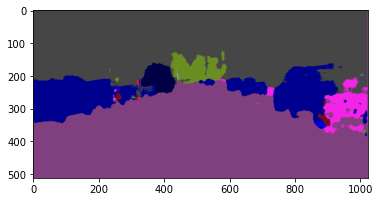

In [10]:
run(0,True)

In [11]:
print(original_images[0])

city1.jpg
